Build the neuron.

In [27]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# --- Build simple cell (soma with HH, passive dendrite) ---
soma = h.Section(name='soma')
dend = h.Section(name='dend')

soma.L = soma.diam = 20.0
dend.L = 200.0
dend.diam = 1.0
dend.connect(soma(1))

for sec in (soma, dend):
	sec.Ra = 100
	sec.cm = 1.0

soma.insert('hh')
dend.insert('pas')
dend.g_pas = 1e-4
dend.e_pas = -65.0
dend.nseg = 11

Set up simulation parameters.

In [31]:
# --- Simulation parameters ---
tstop = 80.0  # ms
stim_time = 20.0  # ms: when the NetStim fires
netcon_delay = 1.0  # ms
weight = 0.001  # µS for ExpSyn (conductance units)

# --- Locations: 5 evenly spaced along the dendrite (avoid endpoints) ---
nloc = 5
locs = np.linspace(0.1, 0.9, nloc)  # fractions along dend: 0..1

Run the simulation and convert the results into vectors for plotting.

In [32]:
# Containers for results
all_v_dend = []   # list of numpy arrays (one per location)
all_v_soma = []   # list of numpy arrays (one per location)
t_numpy = None

# Run separate simulation for each location
for x in locs:
    # create synapse on dendrite at x
    syn = h.ExpSyn(dend(x))
    syn.tau = 2.0
    syn.e = 0.0

    # single-event NetStim
    ns = h.NetStim()
    ns.start = stim_time
    ns.number = 1
    ns.interval = 1.0
    ns.noise = 0.0

    # connect
    nc = h.NetCon(ns, syn)
    nc.delay = netcon_delay
    nc.weight[0] = weight

    # record
    tvec = h.Vector()
    v_soma = h.Vector()
    v_d = h.Vector()
    tvec.record(h._ref_t)
    v_soma.record(soma(0.5)._ref_v)
    v_d.record(dend(x)._ref_v)

    # run (portable)
    h.finitialize(-65.0)
    h.tstop = tstop
    h.run()

    # collect
    t_arr = np.array(tvec)
    v_soma_arr = np.array(v_soma)
    v_d_arr = np.array(v_d)
    if t_numpy is None:
        t_numpy = t_arr
    all_v_soma.append(v_soma_arr)
    all_v_dend.append(v_d_arr)

    # deactivate and drop references so earlier NetStims don't fire in subsequent runs
    # (setting number=0 is an additional safeguard; del removes Python refs so hoc objects can be GC'd)
    ns.number = 0
    nc.weight[0] = 0.0
    del nc, ns, syn, tvec, v_soma, v_d

# stack results
all_v_soma = np.vstack(all_v_soma)
all_v_dend = np.vstack(all_v_dend)

Plot the results.

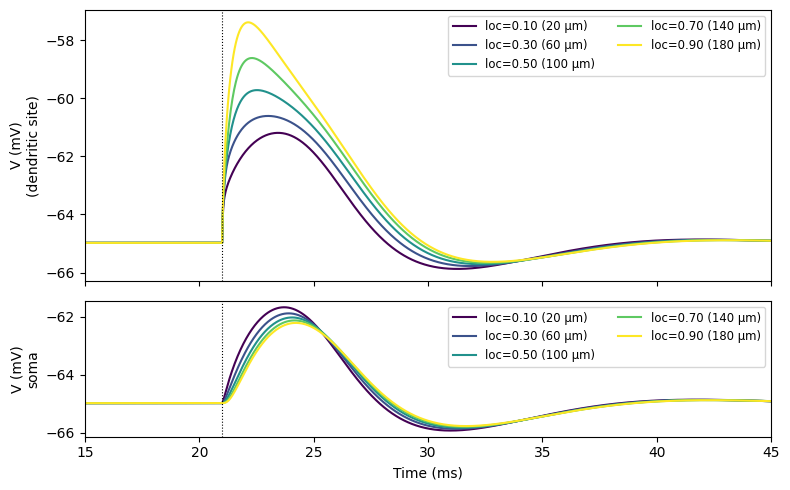

In [33]:
# simple plotting: dendritic traces (top), soma traces (bottom)
fig, (ax_d, ax_s) = plt.subplots(2, 1, sharex=True,
                                 gridspec_kw={'height_ratios': [2, 1]},
                                 figsize=(8, 5))
cmap = plt.get_cmap('viridis')
colors = [cmap(i / (nloc - 1)) for i in range(nloc)]

for i, x in enumerate(locs):
    label = f'loc={x:.2f} ({x * dend.L:.0f} µm)'
    ax_d.plot(t_numpy, all_v_dend[i], color=colors[i], label=label)
    ax_s.plot(t_numpy, all_v_soma[i], color=colors[i], label=label)

ax_d.set_ylabel('V (mV)\n(dendritic site)')
ax_s.set_ylabel('V (mV)\nsoma')
ax_s.set_xlabel('Time (ms)')
ax_d.legend(fontsize='small', ncol=2, loc='upper right')
ax_s.legend(fontsize='small', ncol=2, loc='upper right')

# mark arrival time
arrival = stim_time + netcon_delay
ax_d.axvline(arrival, color='k', linestyle=':', linewidth=0.8)
ax_s.axvline(arrival, color='k', linestyle=':', linewidth=0.8)

plt.xlim(15.0, 45.0)
plt.tight_layout()
plt.show()